# Keras starter kit [full training set, UNet]

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

# Data config
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 64  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 32  # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 2000  # Height to resize all papyrii

# (x, y)
val_location = (600, 500)
val_zone_size = (2000, 1000)

# Model config
BATCH_SIZE = 64
USE_MIXED_PRECISION = True
USE_JIT_COMPILE = False

threshold = 0.2

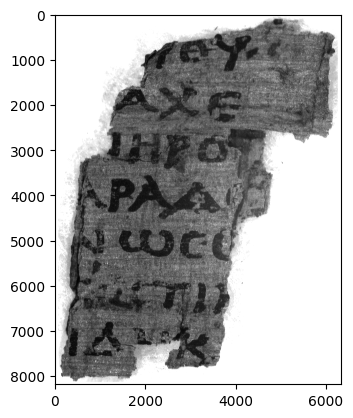

In [2]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

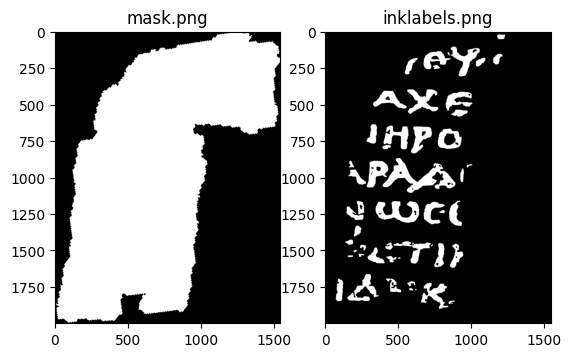

In [3]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (2000, 4642)
mask_test_b: (2000, 2321)
-
mask_train_1: (2000, 1547)
labels_train_1: (2000, 1547)
-
mask_train_2: (2000, 1281)
labels_train_2: (2000, 1281)
-
mask_train_3: (2000, 1380)
labels_train_3: (2000, 1380)


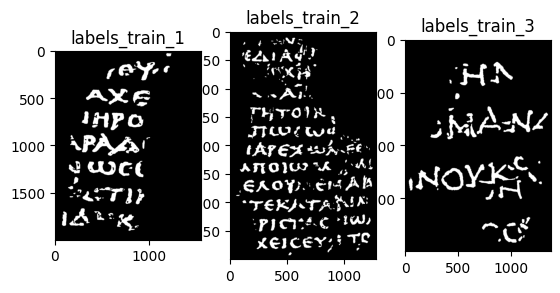

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

32it [00:02, 12.78it/s]


volume_train_1: (2000, 1547, 32), uint16


32it [00:06,  5.24it/s]


volume_train_2: (2000, 1281, 32), uint16


32it [00:01, 16.94it/s]


volume_train_3: (2000, 1380, 32), uint16
total volume: (2000, 4208, 32)


In [8]:
del volume_train_1
del volume_train_2
del volume_train_3

In [9]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (2000, 4208), uint8
mask: (2000, 4208), uint8


In [10]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

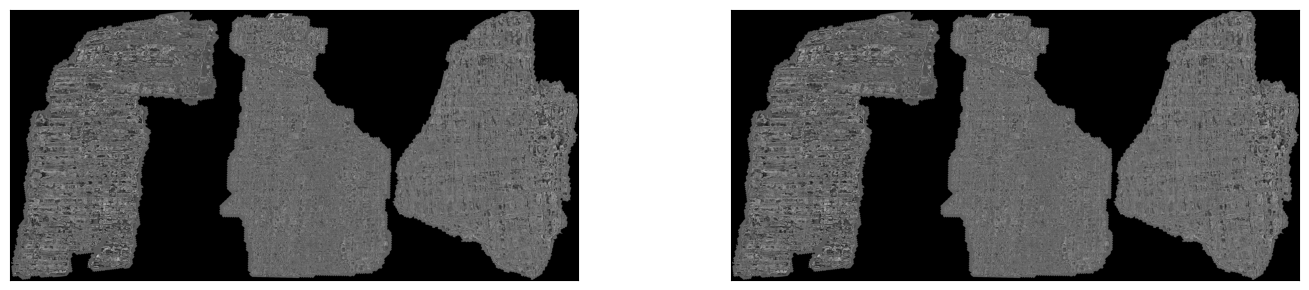

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

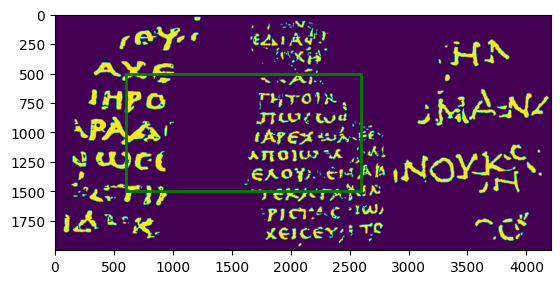

In [12]:
fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [13]:
def sample_random_location(shape):
    random_train_x = np.random.random_integers(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_y = np.random.random_integers(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_location = np.stack([random_train_x, random_train_y], axis=0)
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

# Create a list to store train locations
train_locations = []

# Define the number of train locations you want to generate
num_train_locations = 10000

# Generate train locations
while len(train_locations) < num_train_locations:
    location = sample_random_location_train(0)
    if is_proper_train_location(location):
        train_locations.append(location)

# Convert the list of train locations to a PyTorch tensor
train_locations_ds = np.stack(train_locations, axis=0)

/tmp/ipykernel_1805398/4249771252.py:2: DeprecationWarning: This function is deprecated. Please call randint(64, 1935 + 1) instead
  random_train_x = np.random.random_integers(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
/tmp/ipykernel_1805398/4249771252.py:3: DeprecationWarning: This function is deprecated. Please call randint(64, 4143 + 1) instead
  random_train_y = np.random.random_integers(low=BUFFER, high=shape[1] - BUFFER - 1, size=())


## Visualize some training patches

Sanity check visually that our patches are where they should be.

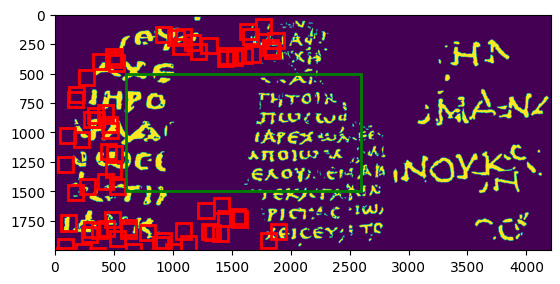

In [14]:
fig, ax = plt.subplots()
ax.imshow(labels)

# Define the number of samples you want to take from train_locations_ds
num_samples = 200

# Iterate over the first 'num_samples' elements in train_locations_ds
for i in range(num_samples):
    x, y = train_locations_ds[i]
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [15]:
from scipy.stats import median_abs_deviation


def extract_subvolume(location, volume):
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :] 
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.median(subvolume, axis=2)
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("median", median)
    # print("MAD", MAD)

    if np.all(median != 0):        
        # MAD = np.stack([MAD for i in range(Z_DIM)], axis=2)
        median = np.stack([median for i in range(Z_DIM)], axis=2)
        # print("mda.shape", MDA.shape, "MD", MDA)
        subvolume = (subvolume / median)
    else:
        subvolume = subvolume / 65536.
    return subvolume

## Create training dataset that yields random subvolumes and their labels

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        location = self.locations[idx]
        x, y = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)        
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        # print(subvolume)
        
        if self.is_train:            
            label = self.labels[x - self.buffer:x + self.buffer, y - self.buffer:y + self.buffer]    
            label = np.where(label == 1, 2 ** 16 - 1, 0).astype(np.uint16)
            # label = label.numpy()
            label = np.stack([label], axis=-1)
            # n_category = 2
            # label = np.eye(n_category)[label]
            
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)            
            performed = A.Compose([            
                A.ToFloat(max_value=2**16-1),
                A.RandomBrightnessContrast(),
                A.HorizontalFlip(),
                A.VerticalFlip(),  
                A.FromFloat(max_value=2 ** 16-1),
            ])(image=subvolume, mask=label)          
            subvolume = performed["image"]
            label = performed["mask"]
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float16))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8) // 255) 
        else:
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float16))
            label = None
        return subvolume, label

# Convert train_locations_ds to a PyTorch tensor
train_locations_tensor = np.stack([x for x in train_locations_ds], axis=0)

# Create an instance of the SubvolumeDataset
train_ds = SubvolumeDataset(train_locations_tensor, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


In [17]:
subvolume_batch, label_batch = train_ds[1]
print(f"subvolume shape: {subvolume_batch.shape}")
print(f"label_batch shape: {label_batch.shape}")

subvolume shape: torch.Size([32, 128, 128])
label_batch shape: torch.Size([1, 128, 128])


## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [18]:
# t0 = time.time()
# n = 200
# for _ in train_ds:
#     pass
# print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

## Create validation dataset

In [19]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Convert the list of val locations to a PyTorch tensor
val_locations_ds = np.stack(val_locations, axis=0)

# Create an instance of the SubvolumeDataset
val_ds = SubvolumeDataset(val_locations_ds, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

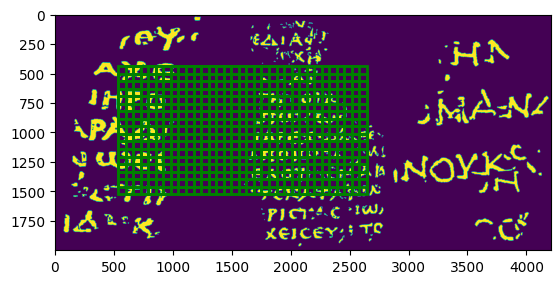

In [20]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [21]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

score = trivial_baseline(val_ds).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

  0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_1805398/1352218617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_label = torch.tensor(batch_label)
100%|██████████| 512/512 [00:01<00:00, 275.63it/s]

Best validation score achievable trivially: 89.68% accuracy


## Augment the training data

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

In [23]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.LeakyReLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        def transpose_conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.LeakyReLU(),
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 2 else 64 * 2**(i - 1), 64 * 2**i, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.LeakyReLU(),
                nn.Conv2d(64 * 2**i, 64 * 2**i, kernel_size=3, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.LeakyReLU(),
            )
            for i in range(2, 4)
        ])


        self.middle = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512),
        )
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                transpose_conv_block(2 ** (i + 7), 2 ** (i + 6)),
                transpose_conv_block(2 ** (i + 6), 2 ** (i + 5)),
                nn.Upsample(scale_factor=2, mode="nearest"),
            )
            for i in range(3, 1, -1)
        ])
        self.final_decoder = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
        )        

    def forward(self, x):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)

        x = self.middle(x)
        
        # print("encoder ok", x.shape)
        for i, layer in enumerate(self.decoder):            
            # print(f"decoder will {i}: ok", x.shape)
            x = torch.cat([x, skip_connections[-i-1]], dim=1)  # Concatenate along channel dimension
            # print(f"decoder with skip connection {i}: ok", x.shape)            
            x = layer(x)            
            # print(f"decoder {i}: ok", x.shape)
        # print("decoder ok")
        x = self.final_decoder(x)
        return x

In [24]:
import os

# Define the model
model = UNet(Z_DIM, 1)
model = nn.DataParallel(model)

if os.path.exists(f"{DATA_DIR}/model.pt"):
    # model.load_state_dict(torch.load(f"{DATA_DIR}/model.pt"))
    pass

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

# Loss, optimizer, and metric
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy = Accuracy(task="binary").to(device)

In [25]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for idx, (subvolumes, labels) in tqdm(enumerate(train_dataloader), leave=False):
        subvolumes, labels = subvolumes.to(device), labels.to(device)        
        labels = labels.float()       
        subvolumes = subvolumes.float() 

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):            
            outputs = model(subvolumes)                 
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        running_accuracy += acc
        
    running_loss /= len(train_dataloader)
    running_accuracy /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for subvolumes, labels in tqdm(val_dataloader, leave=False):
            subvolumes, labels = subvolumes.to(device), labels.to(device)
            labels = labels.float()
            subvolumes = subvolumes.float()
            outputs = model(subvolumes)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            val_loss += loss.item()
            val_accuracy += acc    

    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss:.4f} Accuracy: {running_accuracy:.4f} Val_Loss: {val_loss:.4f} Val_Accuracy: {val_accuracy:.4f}")

    running_loss = 0.0
    running_accuracy = 0.0
    model.train()

torch.save(model.state_dict(), "model.pt")

  0%|          | 0/20 [00:15<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fummicc1/anaconda3/envs/ink-detection/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 161, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable


## Clear up memory

In [ ]:
del volume
del mask
del labels
del train_ds
del val_ds

import gc
gc.collect()

In [ ]:
model = UNet(Z_DIM, 1)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)

## Compute predictions on test data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]

    class TestDataset(Dataset):
        def __init__(self, test_locations, test_volume):
            self.test_locations = test_locations
            self.test_volume = test_volume

        def __len__(self):
            return len(self.test_locations)

        def __getitem__(self, idx):
            location = torch.tensor(self.test_locations[idx])
            subvolume = extract_subvolume(location, self.test_volume)
            subvolume = subvolume.astype(np.float16)
            subvolume = subvolume.transpose((2, 0, 1))
            return location, subvolume

    test_ds = TestDataset(test_locations, test_volume)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float16)
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float16)

    print(f"Compute predictions")

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for loc_batch, patch_batch in tqdm(test_loader):
            loc_batch = loc_batch.to(device)
            patch_batch = patch_batch.to(device)
            predictions = model(patch_batch)            
            predictions = nn.Sigmoid()(predictions)
            predictions = torch.permute(predictions, (0, 2, 3, 1))
            predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
            for (x, y), pred in zip(loc_batch, predictions):
                predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
                predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map


In [ ]:
from skimage.transform import resize as resize_ski
import pathlib

In [ ]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() > threshold, 1, 0)).astype(np.uint8)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0] + 2
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0] + 2

    lengths = ends - starts

    return " ".join(map(str, np.c_[starts, lengths].flatten()))

In [ ]:
print("Id,Predicted", file=open('submission.csv', 'w'))

def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [ ]:
folder = pathlib.Path(DATA_DIR) / "test"
for p in folder.iterdir():
    index = p.stem
    predictions_map = compute_predictions_map(split="test", index=index)
    original_size = cv2.imread(DATA_DIR + f"/test/{index}/mask.png", 0).sha@e[:2]
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1])).squeeze()
    update_submission(predictions_map, index)